In [1]:
# Importar librerías científicas

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import *
import matplotlib.animation as animation
import matplotlib.patches as mpatches

In [2]:
# Crear estilo de plots
# IPython_default = plt.rcParams.copy()

from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [3]:
# Definir clases y funciones necesarias
class System(object):
    def __init__(self, agents):
        self.agents = agents #dynamic    
        self.iterations = 0 #dynamic
        self.transactions = 0 #dynamic

    def getAgents(self):
        return self.agents
    
    def setAgents(self,agents):
        self.agents = agents #dynamic    
    
    def getIterations(self):
        return self.iterations
        
    def getTransactions(self):
        return self.transactions
            
    def evolve(self, deltam, iterations = 1):

        N = self.getN()
        indices = np.arange(N)
        
        for iteration in range(iterations):
            for k in range(N):
                l = np.random.choice(indices, 1)
                self.simulateTransaction(k,l,deltam)
            self.iterations += 1
        
    def simulateTransaction(self, k, l, deltam):
                    
        agents = self.getAgents()
        mny = agents[l] - deltam
        
        if(mny >= 0):
            agents[k] = agents[k] + deltam
            agents[l] = agents[l] - deltam
            self.transactions += 1
            
        self.agents = agents
        
    def getM(self):
        return np.sum(self.getAgents())
    
    def getN(self):
        return len(self.getAgents())
                    

In [4]:
# This class will act as a storage variable for historic system data
class Simulation(object):
    def __init__(self, system):
        self.system = system #dynamic        
        self.agentsHistory = [system.getAgents()] #dynamic
        self.transactionsHistory = [0] #dynamic
        
    def getSystem(self):
        return self.system
        
    def getAgentsHistory(self):
        return self.agentsHistory
    
    def getTransactionsHistory(self):
        return self.transactionsHistory
            
    def run(self, deltam, snapshots = 1):
        
        system = self.getSystem()
        agentsHistory = self.getAgentsHistory()
        transactionsHistory = self.getTransactionsHistory()
        
        for snapshot in range(snapshots):
            system.evolve(deltam, 1)
            agentsHistory.append(system.getAgents())
            transactionsHistory.append(system.getTransactions())
            
        self.system = system
        self.agentsHistory = agentsHistory
        self.transactionsHistory = transactionsHistory
        
    def calculateAverageHistory(self):
                
        averages = []
        agentsHistory = self.getAgentsHistory()
        
        for agents in agentsHistory:
            averages.append(np.average(agents))
        
        return averages
        
    def calculateEntropyHistory(self, C, mMax):
        
        entropies = []
        agentsHistory = self.getAgentsHistory()
        
        for agents in agentsHistory:
            entropies.append(S(agents, C, mMax))
            
        return entropies
    
    def getSimulationHistory(self, C, mMax):
        return self.getAgentsHistory(), self.getTransactionsHistory(), self.calculateAverageHistory(), self.calculateEntropyHistory(C, mMax)

# Function S takes an array of real numbers (i.e. the amount of money each agent has) and calculates entropy
def S(agents, numClasses, mMax):
    frequencies, binEdges = np.histogram(agents, bins=numClasses, range=[0,mMax])
    agents = np.array(agents)
    positiveFrequencies = frequencies[frequencies > 0]
    return N*np.log(N) - np.sum(positiveFrequencies*np.log(positiveFrequencies)) 

In [5]:
class SimulationWithWellness(Simulation):
    def __init__(self, system, o1):
        super().__init__(system)
        self.o1 = o1

    def calculateWellnessHistory(self, C, mMax):
                
        wellnesses = []
        agentsHistory = self.getAgentsHistory()
        
        o1 = self.o1
        
        for agents in agentsHistory:
            wellnesses.append(O(agents, C, mMax, o1))
        
        return wellnesses
    
    def getSimulationHistory(self, C, mMax):
        return self.getAgentsHistory(), self.getTransactionsHistory(), self.calculateAverageHistory(), self.calculateEntropyHistory(C, mMax), self.calculateWellnessHistory(C, mMax)

    
def O(agents, C, mMax, o1):
    
    frequencies, binEdges = np.histogram(agents, bins=C, range=[0,mMax])
    wellnessSum = 0
    
    for k in range(len(binEdges)-1):
        frequency = frequencies[k]
        ags = np.array(agents).copy()
        ags = ags[ags >= binEdges[k]]
        ags = ags[ags < binEdges[k+1]]
        Mk = 0
        Mk = np.sum(ags)
        wellnessSum += frequency*o1(Mk)
        
    return wellnessSum

In [6]:
def deltaDistribution(M,N):
    return np.ones(N)*M/N

def uniformDistribution(M,N,numClasses):
    
    G = int(N/numClasses)
    ags = []

    for l in range(G):
        for k in range(numClasses):
            ags.append(l)
    
    ags = np.array(ags)*M/np.sum(ags)
    return ags, np.max(ags)

def kill(n,agents):
    # kill the n last agents in array and distribute their money
    if n >= len(agents):
        print('You were about to kill everyone. Agents left intact.')
        return agents
    
    agents = np.array(agents)
    heritage = np.sum(agents[-n:])
    alive = agents[:-n]
    alive = alive + heritage/len(alive)
    return alive

def birth(n,agents):
    # birth new baby agents with no money
    agents = np.array(agents)
    return np.concatenate((agents,np.zeros(n)))
 
def win(m,agents):
    agents = agents + m/len(agents)
    
    debt = np.abs(np.sum(agents[agents < 0]))
    
    agents = agents + debt/len(agents)
    return agents
    
def mcIdeal(agents):
    return 10*np.average(agents)

def alpha(avg,mc):
    #equals a/b
    return avg/mc

def expectedWellnessAlpha(ratioAlpha):
    return N/(1+ratioAlpha)

def expectedWellnessBeta(ratioBeta):
    return N*ratioBeta/(ratioBeta + 1)

def discreteWellness(N,a,b,classInterval, C):
    Ac = discreteNormalization(b,classInterval,C)
    return N*(1 - Ac*((1-np.exp(-(a+b)*classInterval*(C+1)))/(1-np.exp(-(a+b)*classInterval))) + Ac)
    
def discreteNormalization(b,classInterval,C):
    return (np.exp(b*classInterval) - 1)/(1 - np.exp(-b*classInterval*C))

In [7]:
# Set fundamental system parameters
M = 10000
N = 5000
mMax = 40
C = 40


# Create initial population
agents = deltaDistribution(M,N)

# Calculate one final fundamental parameter
mc = mcIdeal(agents)

# Bootstrap the simulation
sys = System(agents)

# Set evolution variables
deltam = 0.5
iterations = 5

def o1(M):
    return 1 - np.exp(-(1/mc)*M)



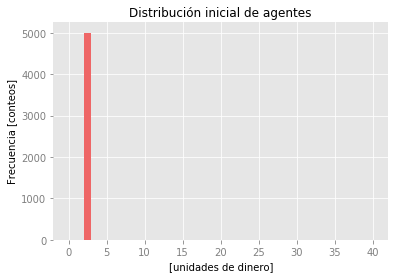

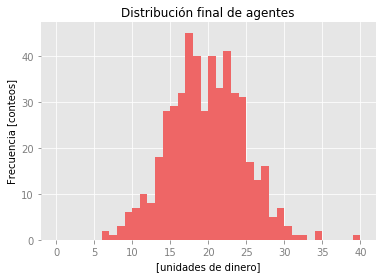

In [8]:
# Some agents are about to leave us. How many?
thisMany = 25

alphaHistory = [alpha(np.average(sys.getAgents()),mc)]
killHistory = [0]
wellnessHistory = [O(sys.getAgents(),C,mMax,o1)]
popHistory = [N]

plt.title('Distribución inicial de agentes')
plt.ylabel('Frecuencia [conteos]')
plt.xlabel('[unidades de dinero]')
plt.hist(sys.getAgents(), bins=C, range=[0,mMax])
plt.show()

iterations = 1


for n in range(180):
    agents = kill(thisMany,sys.getAgents())
    sys.setAgents(agents)
    sys.evolve(deltam,iterations)
    popHistory.append(N - (n+1)*thisMany)
    alphaHistory.append(alpha(np.average(sys.getAgents()),mc))
    wellnessHistory.append(O(sys.getAgents(),C,mMax,o1))

plt.title('Distribución final de agentes')
plt.ylabel('Frecuencia [conteos]')
plt.xlabel('[unidades de dinero]')
plt.hist(sys.getAgents(), bins=C, range=[0,mMax])
plt.show()


In [37]:
print(np.max(sys.getAgents()))
print(mc)
print(np.average(sys.getAgents()))

35.605999999999995
20.0
19.999999999999993


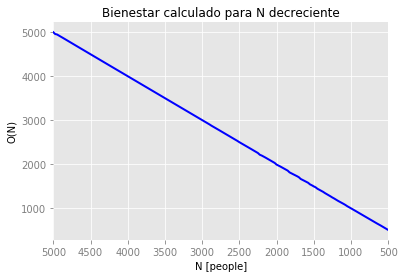

In [38]:

plt.title('Bienestar calculado para N decreciente')
plt.ylabel('O(N)')
plt.xlabel('N [people]')

plt.plot(popHistory,wellnessHistory, 'b')
plt.xlim(popHistory[0], popHistory[-1])
plt.show()




In [39]:


classInterval = mMax/C

Odiscrete = discreteWellness(N,np.array(alphaHistory)*(1/np.average(sys.getAgents())),1/np.average(sys.getAgents()),classInterval, C)


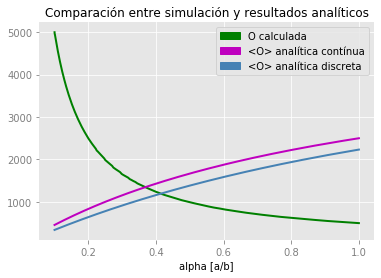

In [40]:
plt.title('Comparación entre simulación y resultados analíticos')
# plt.ylabel()
plt.xlabel('alpha [a/b]')

S1_patch = mpatches.Patch(color='g', label='O calculada')
S2_patch = mpatches.Patch(color='m', label='<O> analítica contínua')
S3_patch = mpatches.Patch(color='steelblue', label='<O> analítica discreta')

plt.legend(handles=[S1_patch,S2_patch,S3_patch])

plt.plot(alphaHistory,wellnessHistory, 'g')
plt.plot(alphaHistory,expectedWellnessBeta(np.array(alphaHistory)), 'm')
plt.plot(alphaHistory, Odiscrete, 'steelblue')
plt.show()

In [178]:
# Set fundamental system parameters
M = 10000
N = 5000
mMax = 600
C = 40


# Create initial population
agents = deltaDistribution(M,N)

# Calculate one final fundamental parameter
mc = 10000*mcIdeal(agents)

# Bootstrap the simulation
sys = System(agents)

# Set evolution variables
deltam = 0.5
iterations = 5

def o1(M):
    return 1 - np.exp(-(1/mc)*M)



In [179]:
# Some agent is going to win some money. How much?
thisMuch = 50000

alphaHistory = [alpha(np.average(sys.getAgents()),mc)]
winHistory = [0]
wellnessHistory = [O(sys.getAgents(),C,mMax,o1)]


plt.title('Distribución inicial de agentes')
plt.ylabel('Frecuencia [conteos]')
plt.xlabel('[unidades de dinero]')
plt.hist(sys.getAgents(), bins=C, range=[0,mMax])
plt.show()

sys.evolve(deltam,10)
iterations = 1


for n in range(50):
    agents = win(thisMuch,sys.getAgents())
    sys.setAgents(agents)
#     sys.evolve(deltam,iterations)
    winHistory.append((n+1)*thisMuch)
    alphaHistory.append(alpha(np.average(sys.getAgents()),mc))
    wellnessHistory.append(O(sys.getAgents(),C,mMax,o1))

winHistory = np.array(winHistory) + np.ones(len(winHistory))*M
    
plt.title('Distribución final de agentes')
plt.ylabel('Frecuencia [conteos]')
plt.xlabel('[unidades de dinero]')
plt.hist(sys.getAgents(), bins=C, range=[0,mMax])
plt.show()

In [180]:
print(np.max(sys.getAgents()))
print(mc)
print(np.average(sys.getAgents()))

506.0
200000.0
502.0


<IPython.core.display.Javascript object>


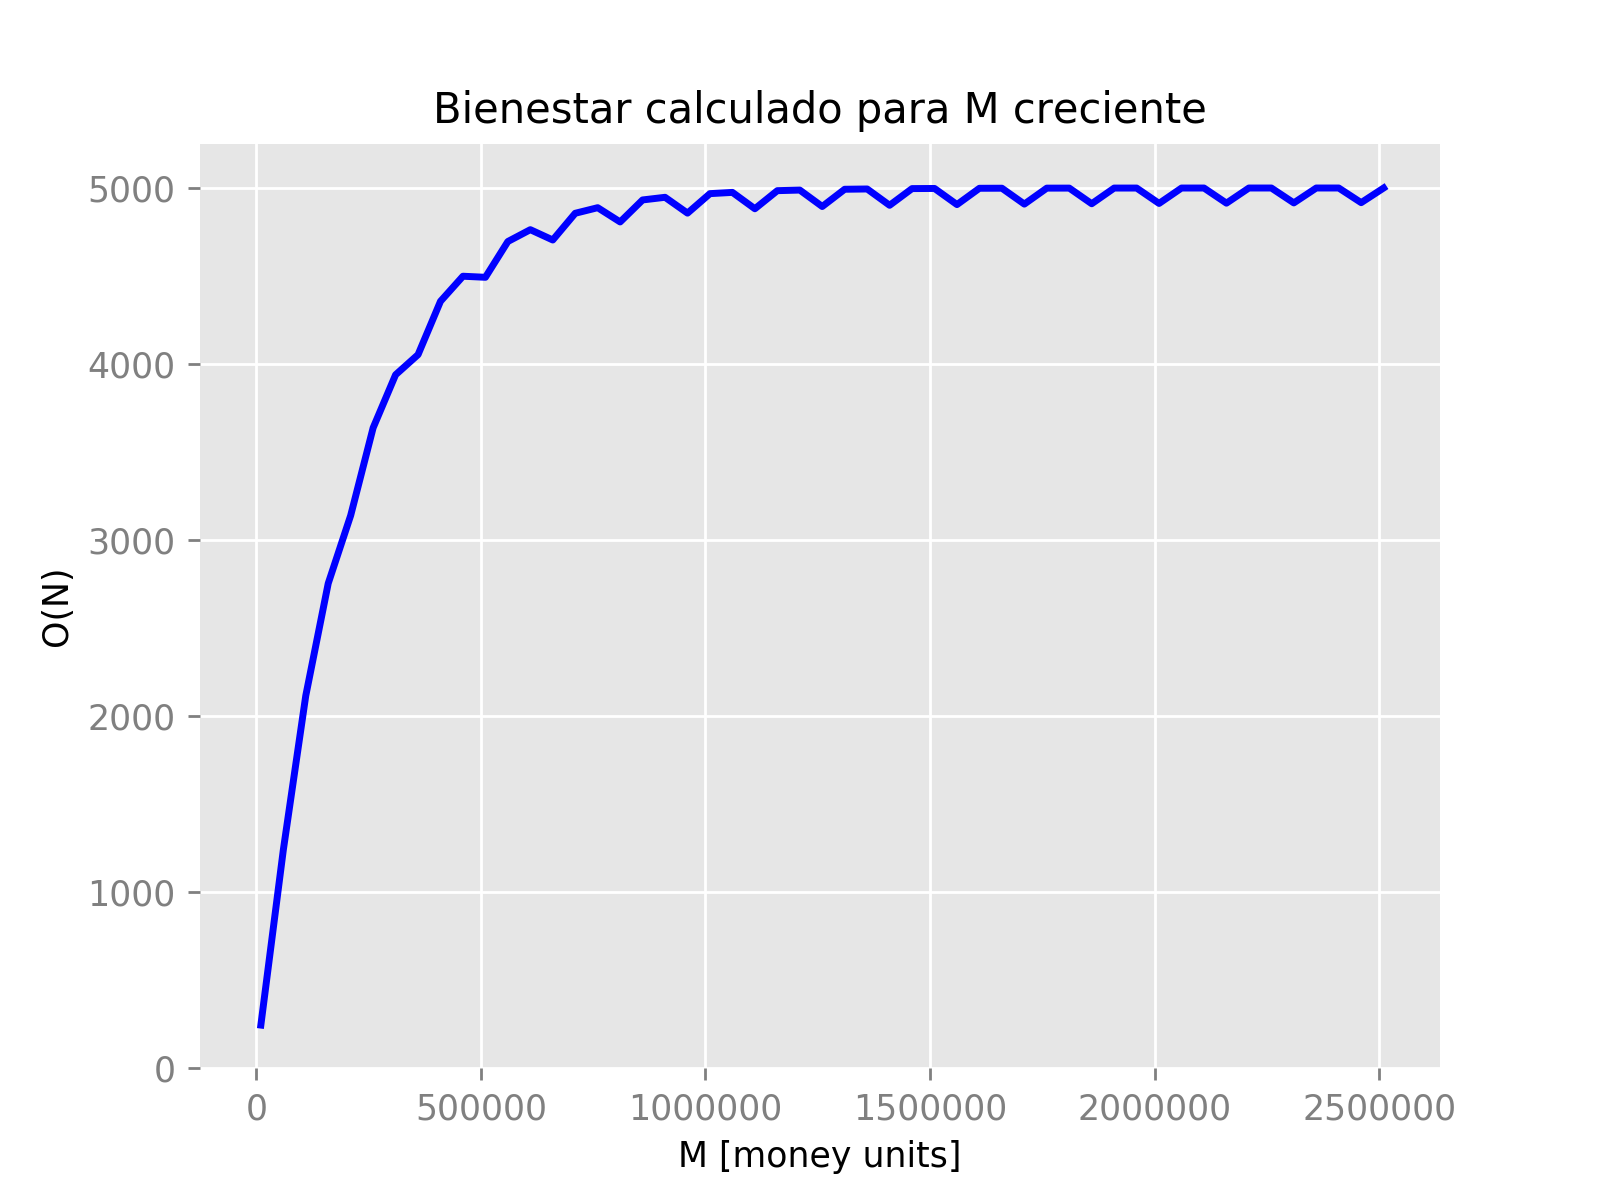

In [181]:

%matplotlib notebook

plt.title('Bienestar calculado para M creciente')
plt.ylabel('O(N)')
plt.xlabel('M [money units]')



plt.plot(np.array(winHistory),wellnessHistory, 'b')
# plt.xlim(winHistory[0], winHistory [-1])


# plt.ylim(0,N)

plt.show()



<IPython.core.display.Javascript object>


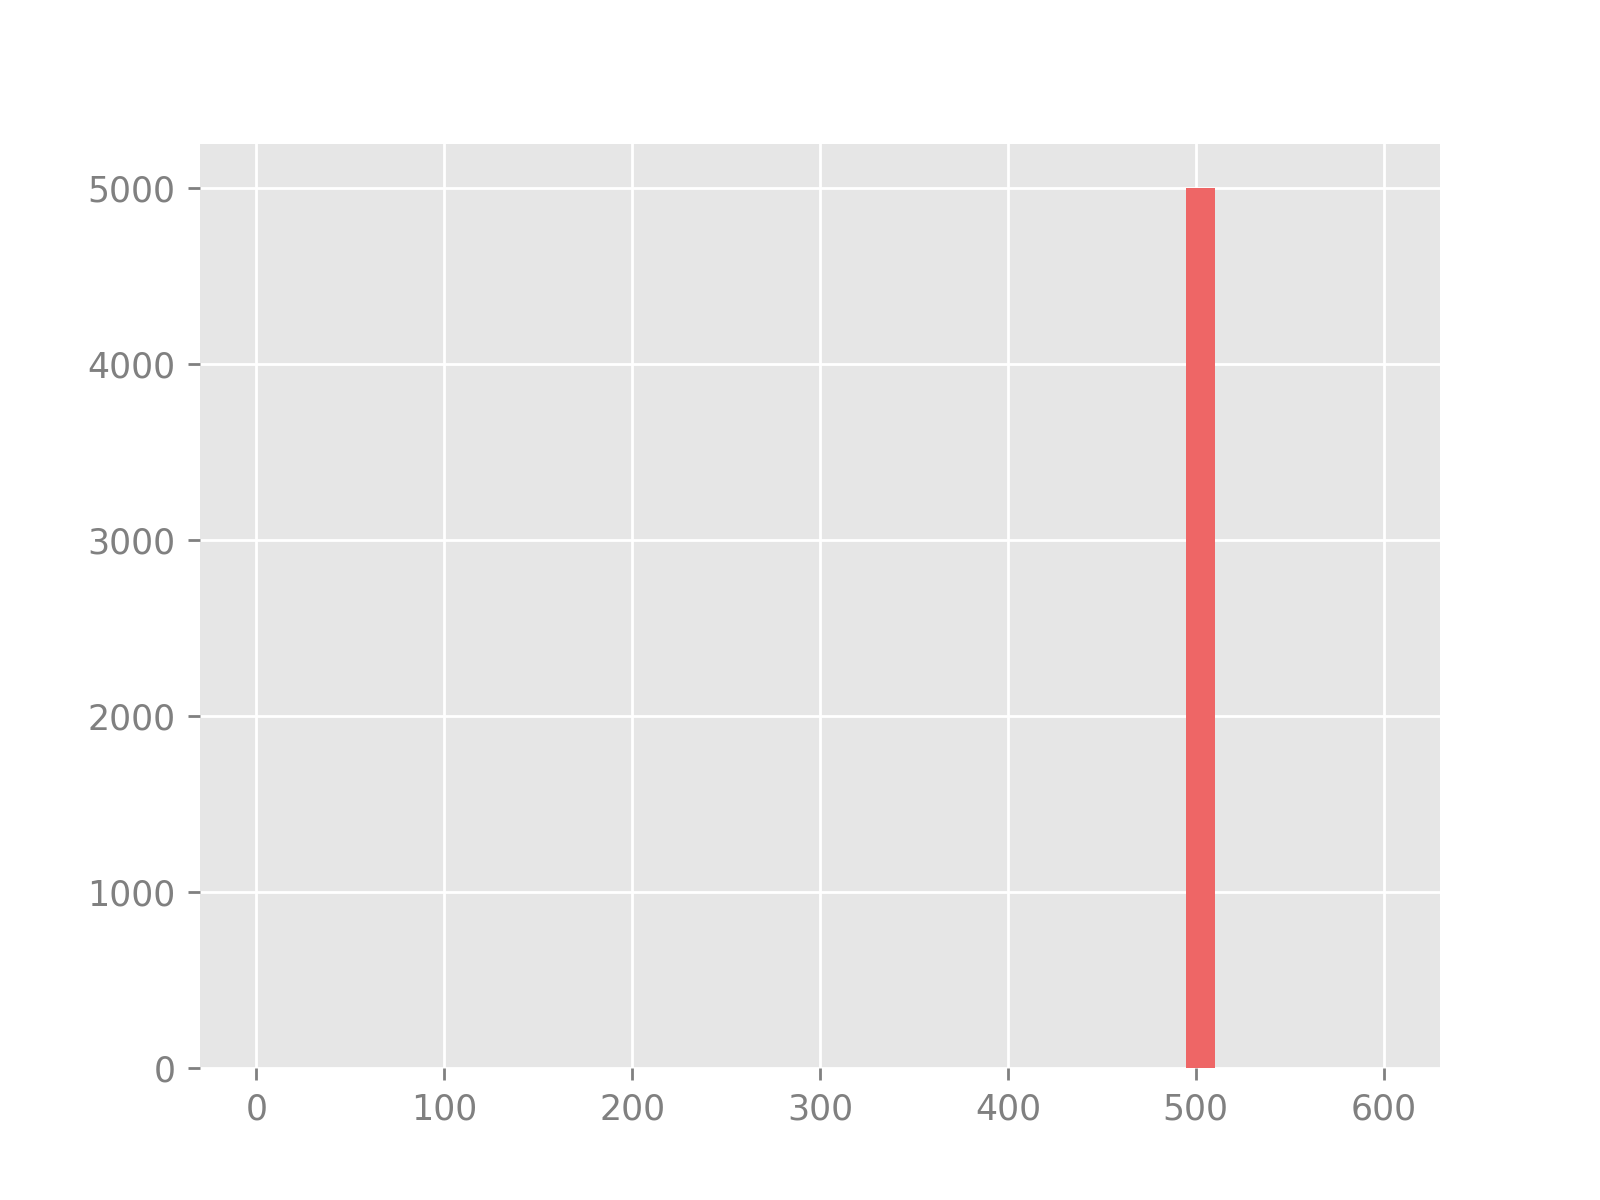

[502.5 503.5 502.5 ... 501.  503.5 505. ]


In [184]:
%matplotlib notebook
plt.hist(sys.getAgents(), bins=C,range=[0,mMax])
print(sys.getAgents())